In [63]:
%matplotlib inline

import json
from skimage.io import imread, imshow
from IPython.display import HTML
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from io import BytesIO
import base64
from skimage.transform import resize
from glob import iglob
pd.set_option('max_colwidth', -1)

In [1]:
json_dir_path = 'label_me_json'

(1600, 1200)



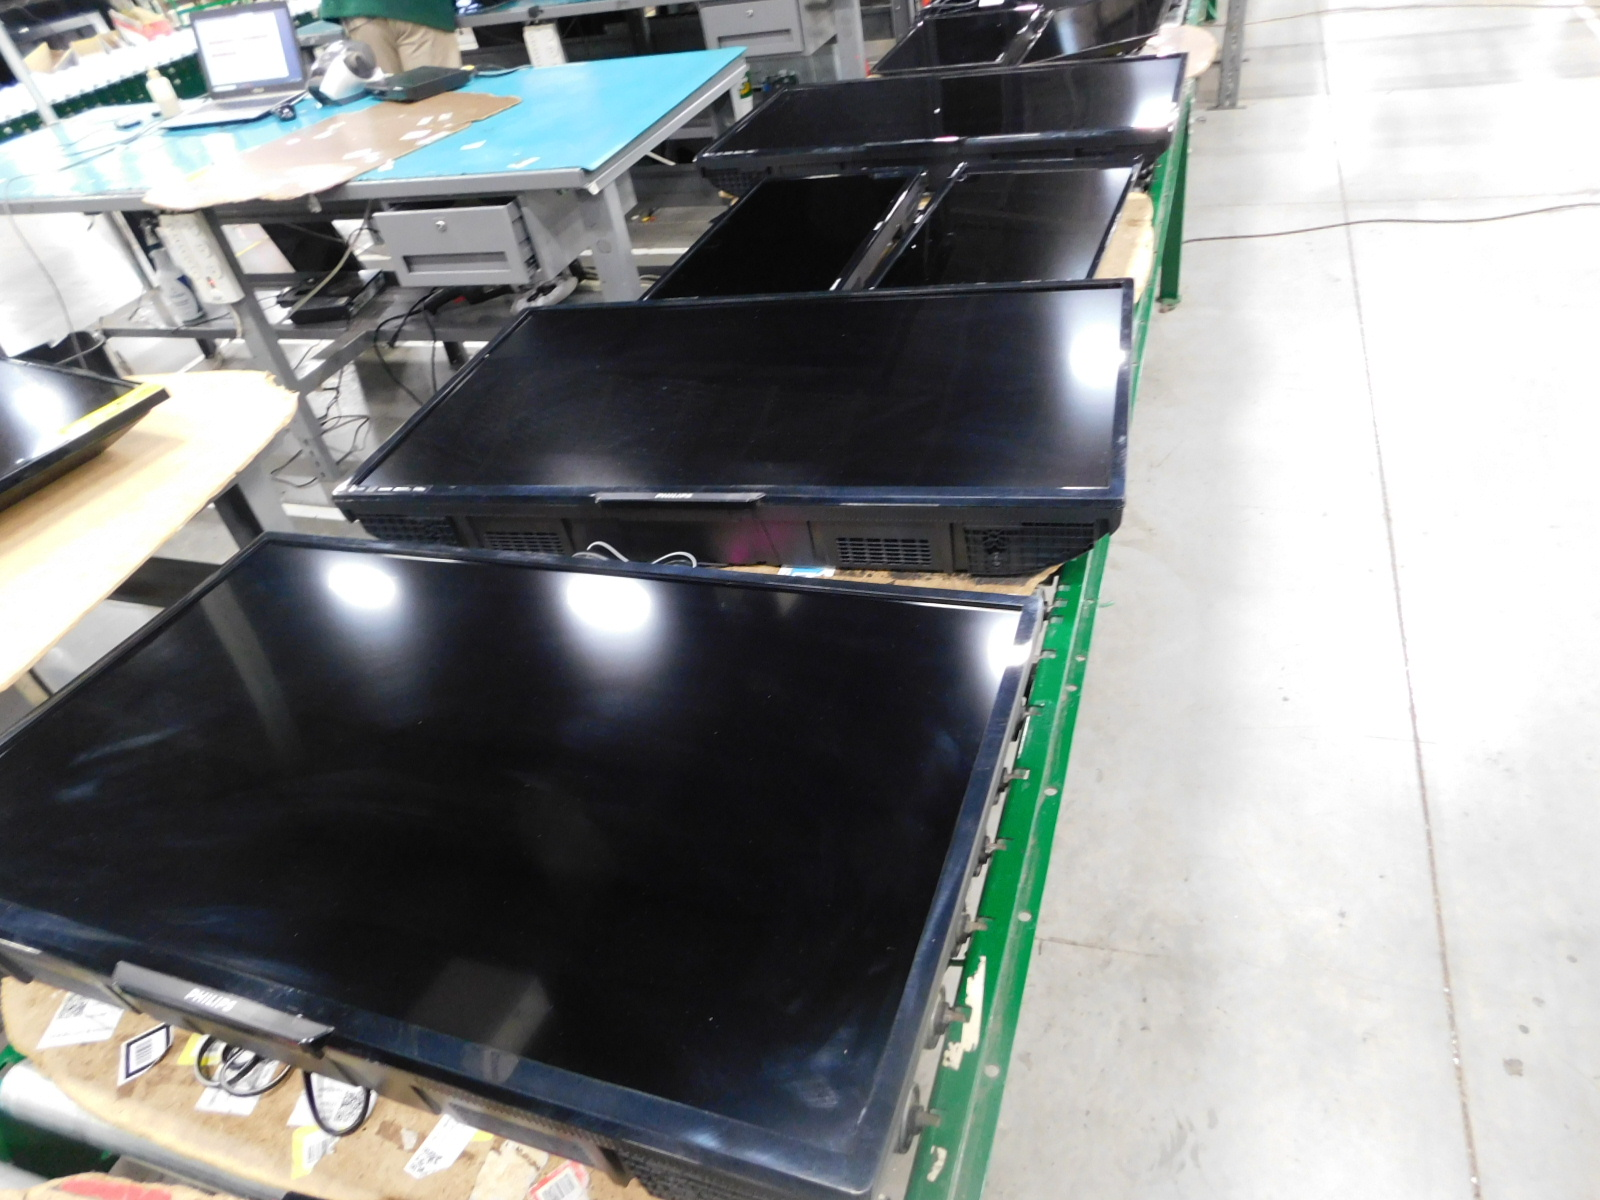

In [33]:
filename = 'label_me_json/20180226093432.json'

with open(filename) as f:
    data = json.load(f)
    
img_base64 = data['imageData']
img_data = Image.open(BytesIO(base64.b64decode(img_base64)))
print(img_data.size)
img_template = '<img src="data:image/png;base64,{}" />'
HTML(img_template.format(img_base64))

In [4]:
def calc_bounding_box(points):
    points = np.array(points)
    x = np.min(points[:, 0])
    y = np.min(points[:, 1])
    w = np.max(points[:, 0]) - x
    h = np.max(points[:, 1]) - y
    return [x, y, w, h]

def preprocess_data(data):
    img_data = data['imageData']
    img_data = Image.open(BytesIO(base64.b64decode(img_data)))
    bbox_list = [calc_bounding_box(shape['points']) for shape in data['shapes']]
    label = len(bbox_list)
    return img_data, bbox_list, label

# ラベルの前処理

+ ラベルは1点1点、のデータが保存されています
+ 以前学習したデータは、左上の座標と矩形の幅と縦の長さの情報を格納しておりましたので、まずは矩形のデータに変換していきたいと思います。

In [5]:
img_tag_template = '<img src="data:image/png;base64,{}" />'


def annotation_and_to_base64(pil_img, ann_list, rate=0.5):
    w, h = pil_img.size
    pil_img = pil_img.resize((int(w * rate), int(h * rate)))
    draw = ImageDraw.Draw(pil_img, 'RGBA')
    for pos in ann_list:
        pos = list(map(lambda x: int(x * rate), pos))
        draw.rectangle(
            [(pos[0], pos[1]), (pos[0]+pos[2], pos[1]+pos[3])],
            outline=(255,0,0,0),
            fill=(255, 0, 0, 100)
        )

    del draw

    output = BytesIO()
    pil_img.save(output, format='PNG')
    return base64.b64encode(output.getvalue()).decode()

def img_array_to_base_64(img_array, rate=0.5):
    pil_img = Image.fromarray(img_array)
    w, h = pil_img.size
    pil_img = pil_img.resize((int(w * rate), int(h * rate)))
    output = BytesIO()
    pil_img.save(output, format='PNG')
    return base64.b64encode(output.getvalue()).decode()

def visualize_data(data):
    return {
        'aimage': img_tag_template.format(annotation_and_to_base64(img, ann_list)),
        'label': annotation_list_to_label(ann_list),
    }

In [6]:
def labeled_data_to_html(path):
    try:
        with open(path) as f:
            data = json.load(f)
    except Exception as e:
        print(path, str(e))
        return None
    img_data, bbox_list, label = preprocess_data(data)
    return img_template.format(annotation_and_to_base64(img_data, bbox_list, rate=0.1))

,index,img_path,img
311,311,/home/disk1/data_available/sasaki_project/json/276.json,
153,153,/home/disk1/data_available/sasaki_project/json/249.json,
64,64,/home/disk1/data_available/sasaki_project/json/234.json,
233,233,/home/disk1/data_available/sasaki_project/json/304.json,
150,150,/home/disk1/data_available/sasaki_project/json/187.json,
48,48,/home/disk1/data_available/sasaki_project/json/75.json,
163,163,/home/disk1/data_available/sasaki_project/json/225.json,
122,122,/home/disk1/data_available/sasaki_project/json/320.json,
129,129,/home/disk1/data_available/sasaki_project/json/55.json,
62,62,/home/disk1/data_available/sasaki_project/json/227.json,

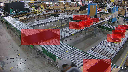
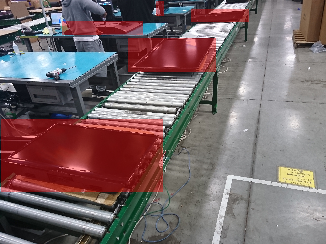
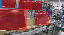
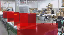
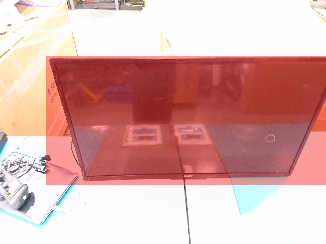
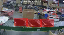
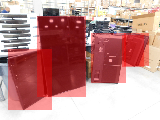
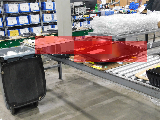
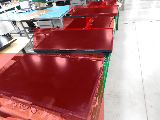
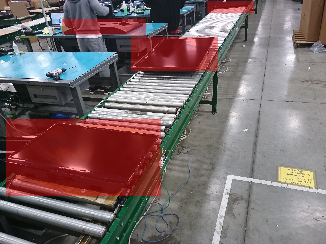

In [28]:
offset = 0
limit = 10
img_df = pd.Series([path for path in iglob(json_dir_path + '/*')]).reset_index().sample(limit)
img_df.columns = ['index', 'img_path']
img_df.loc[:, 'img'] = img_df['img_path'].apply(labeled_data_to_html)
HTML(img_df.to_html(escape=False))